# 5G Attack Detection - Data Discovery
 César de Paula Morais - PORVIR Winet
 
 Rodado em Ubuntu WSL em um i7-11390H e 16Gb DDR4 de RAM


In [4]:
# Imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from minisom import MiniSom
from scipy import stats

from joblib import Parallel, delayed 
import multiprocessing

import pickle

## Funções Auxiliares

In [2]:
class Aux:
    @classmethod
    def plot_histogram(cls, data: list, color_scheme=None):
        plt.scatter(range(len(data)), data, c=color_scheme)
        plt.ylim(-1, 1)
        plt.axhline(0, color='black', linestyle='--')

        plt.show()

## Entendimento do CSV

In [2]:
df = pd.read_csv("5G_attack_detection_ds.csv")
df = df.dropna()
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,49,55,48,51,48,51,48,53,51,102,...,54,56,50,98,101,101,102,48,56,1
1,102,101,51,56,50,102,98,100,57,52,...,99,54,101,54,99,100,99,102,52,1
2,51,52,102,102,48,48,52,100,48,48,...,48,48,48,48,48,48,48,48,48,1
3,52,50,97,51,48,49,50,101,56,54,...,48,48,48,48,48,48,48,48,48,1
4,51,52,102,102,48,53,56,48,48,48,...,53,97,48,53,55,49,101,49,55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48343,51,52,102,102,48,48,99,100,48,48,...,48,48,48,48,48,48,48,48,48,1
48344,53,53,57,53,50,52,53,101,52,102,...,52,49,55,97,100,48,53,54,56,1
48345,53,48,53,53,53,52,50,48,50,102,...,48,48,48,48,48,48,48,48,48,-1
48346,54,101,48,48,48,48,48,48,98,49,...,48,48,48,48,48,48,48,48,48,-1


In [4]:
df.iloc[:, 1024].value_counts()

 1    24174
-1    24174
Name: 1024, dtype: int64

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
count,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,...,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.000000,48348.00000
mean,57.432365,68.335443,63.137958,64.065008,52.096364,54.951063,54.635869,56.703276,60.889303,67.438922,...,53.245987,53.251965,53.278915,53.235894,53.704145,53.322930,55.116716,53.189687,55.314594,0.00000
std,15.523045,22.184792,23.031216,22.575152,11.884525,15.395220,14.374543,17.899496,19.965914,23.359033,...,14.434037,14.206878,14.373414,14.279368,14.889891,14.179228,16.706066,14.302034,17.111443,1.00001
min,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,-1.00000
25%,51.000000,52.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,-1.00000
50%,52.000000,55.000000,49.000000,51.000000,48.000000,49.000000,50.000000,48.000000,51.000000,54.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,0.00000
75%,54.000000,98.000000,98.000000,98.000000,52.000000,52.000000,53.000000,53.000000,56.000000,98.000000,...,49.000000,50.000000,49.000000,50.000000,50.000000,50.000000,51.000000,50.000000,50.000000,1.00000
max,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,1.00000


## Data Discovery

### Usando Correlação de Pearson

A correlação de Pearson avalia a relação linear entre duas variáveis **contínuas**. Como nossa coluna de ataques é binária (+1 e -1), esse não é o método mais recomendado, mas vamos observar os resiultados mesmo assim.

In [4]:
pearson_correlation = df.iloc[:, :-1].corrwith(df['1024'], method='pearson')

pearson_highest_correlation = pearson_correlation[(pearson_correlation > 0.5) | (pearson_correlation < -0.5)]
print(pearson_highest_correlation)

2     0.607133
3     0.617595
24   -0.503442
25   -0.585835
65    0.538109
74    0.577682
dtype: float64


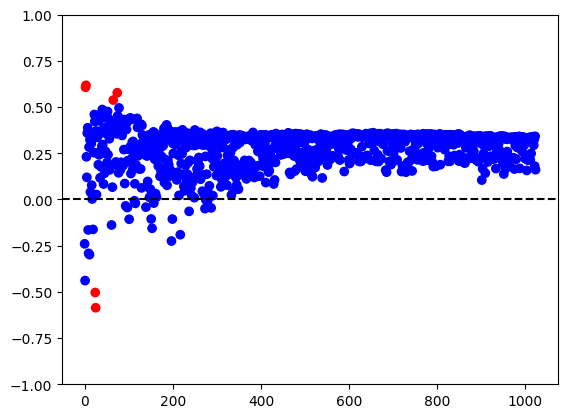

In [5]:
# Color higher variables
pearson_color_scheme = np.where(abs(pearson_correlation) > 0.5, 'r', 'b')

Aux.plot_histogram(pearson_correlation, pearson_color_scheme)

### Usando [Coeficiente de correlação ponto-bisserial](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_ponto-bisserial)

É semelhante à Pearson, mas para uma variável binária

In [6]:
# Calculate point-biserial correlation coefficient for each integer variable
pbc_correlations = []
for column in df.columns[:-1]:  # Exclude the last column (binary variable)
    correlation, p_value = stats.pointbiserialr(df[column], df['1024'])
    pbc_correlations.append(correlation)

pbc_correlations = np.array(pbc_correlations)

pbc_highest_correlation = pbc_correlations[(pbc_correlations > 0.5) | (pbc_correlations < -0.5)]
print(pbc_highest_correlation)

[ 0.60713332  0.61759462 -0.50344192 -0.58583542  0.53810944  0.57768162]


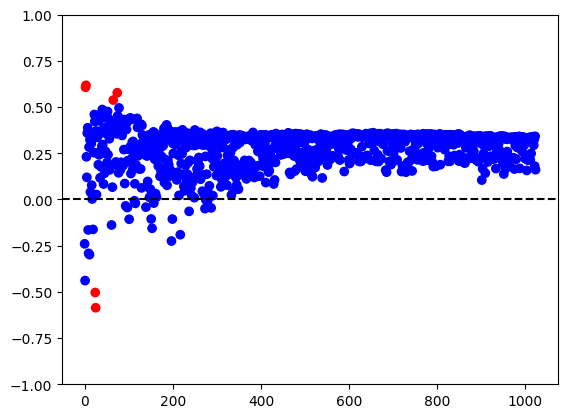

In [7]:
# Color higher variables
pbc_color_scheme = np.where(abs(pbc_correlations) > 0.5, 'r', 'b')

Aux.plot_histogram(pbc_correlations, pbc_color_scheme)

Ambos os métodos deram resultados iguais - isso pode ser explicado pelo fato de que a Correlação Ponto-Bisserial é, na realidade, um caso específico de aplicação de Pearson. Ele geralmente é usado quando nossa variável é binária, mas tem certa continuidade, contextualmente [(ex: nível de ansiedade pode ser considerada uma escala contínua, mas pode ser binarizada como alta/baixa.)](https://cran.r-project.org/web/packages/correlation/vignettes/types.html#:~:text=Point%2DBiserial%20is%20equivalent%20to,classified%20dichotomously%20as%20high%2Flow.).

Esse claramente não é o caso dos ataques, que são por natureza binários.

## Redução de Dimensionalidade
Vamos reduzir a dimensionalidade do nosso banco de dados usando duas técnicas - PCA e Self Organizing Maps:

### PCA

In [10]:
# 1. Separar as features (variáveis independentes)
X = df.iloc[:, :-1]

# 2. Padronizar as features para ter média 0 e desvio padrão 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Inicializar e ajustar o modelo PCA
pca = PCA()
pca.fit(X_scaled)

# 4. Transformar os dados nas componentes principais
X_pca = pca.transform(X_scaled)

# 5. Verificar a variância explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_
print("Variância explicada por cada componente principal:", explained_variance_ratio)


Variância explicada por cada componente principal: [2.81982104e-01 2.55025405e-02 1.71069150e-02 ... 2.18045160e-04
 1.95722847e-04 1.43643170e-04]


O scree plot é uma forma de verificar qual o melhor número de componentes selecionar para explicar nossos dados. Cada ponto no eixo y corresponde à porcentagem da variabilidade total do conjunto de dados explicada por um determinado componente principal.

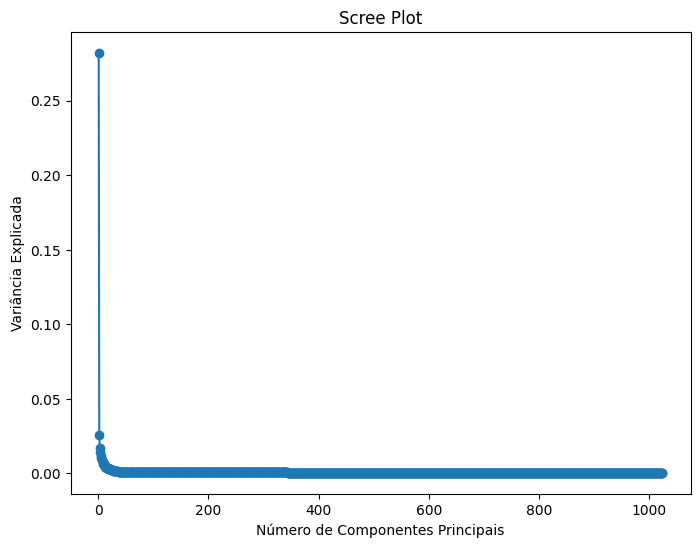

In [11]:
# Plotar Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.title('Scree Plot')
plt.show()

Como o gráfico descende muito rapidamente, vamos verificar apenas os 10 primeiros componentes principais

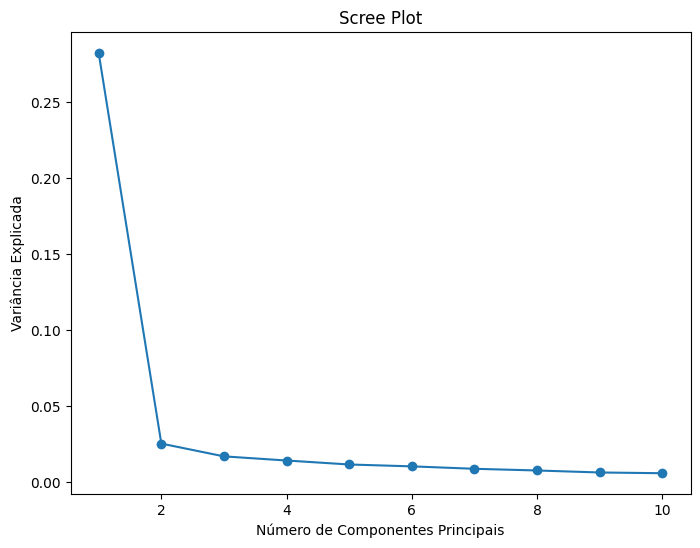

In [12]:
first_10 = explained_variance_ratio[:10]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(first_10) + 1), first_10, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.title('Scree Plot')
plt.show()

Vamos selecionar, então, apenas os 2 primeiros componentes principais.

In [13]:
num_components = 2
X_pca_selected = X_pca[:, :num_components]

Vamos agora plotar nossos dados usando apenas os 2 componentes principais, e verificar sua relação com os ataques (pontos vermelhos são ataques)

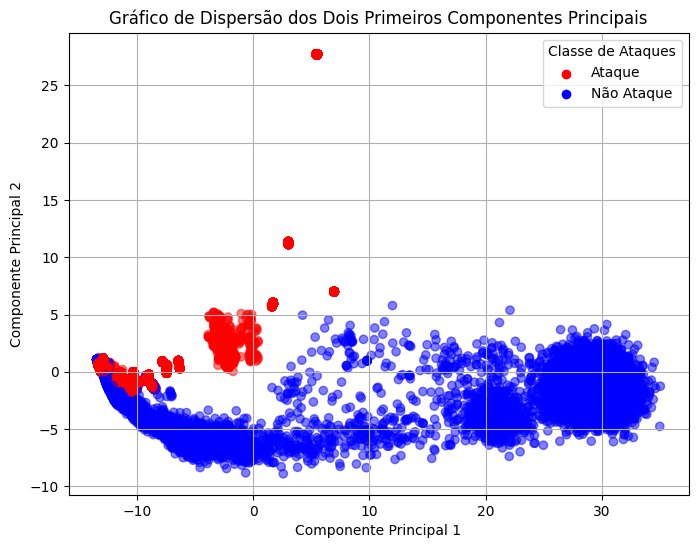

In [14]:
componente1 = X_pca_selected[:, 0]
componente2 = X_pca_selected[:, 1]

attack_classes = df['1024']

# Mapear os valores de ataque para cores específicas
colors = {-1: 'red', 1: 'blue'}
labels = {-1: 'Ataque', 1: 'Não Ataque'}

plt.figure(figsize=(8, 6))
plt.scatter(componente1, componente2, c=attack_classes.map(colors), alpha=0.5)
plt.title('Gráfico de Dispersão dos Dois Primeiros Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)

# Adicionar legenda manualmente
for attack_class, color in colors.items():
    plt.scatter([], [], c=color, label=labels[attack_class])
plt.legend(title='Classe de Ataques')

plt.show()

Como outra alternativa, vamos rodar o PCA sem normalizar nossos dados.

In [8]:
X_2 = df.iloc[:, :-1]

# 3. Inicializar e ajustar o modelo PCA
pca_2 = PCA()
pca_2.fit(X_2)

# 4. Transformar os dados nas componentes principais
X2_pca = pca_2.transform(X_2)

# 5. Verificar a variância explicada por cada componente principal
explained_variance_ratio_2 = pca_2.explained_variance_ratio_
print("Variância explicada por cada componente principal:", explained_variance_ratio_2)

Variância explicada por cada componente principal: [2.57358390e-01 2.94467760e-02 2.09346751e-02 ... 2.58199270e-04
 2.49556624e-04 2.04854355e-04]


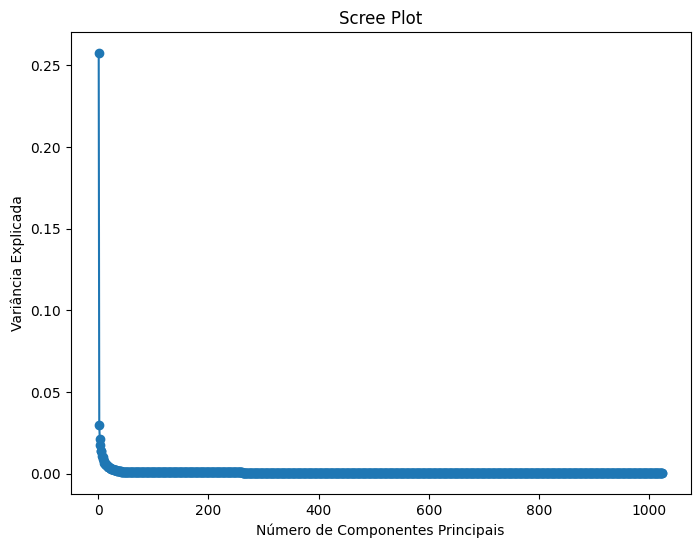

In [9]:
# Plotar Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio_2) + 1), explained_variance_ratio_2, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.title('Scree Plot')
plt.show()

Selecionando novamente os 2 primeiros componentes:

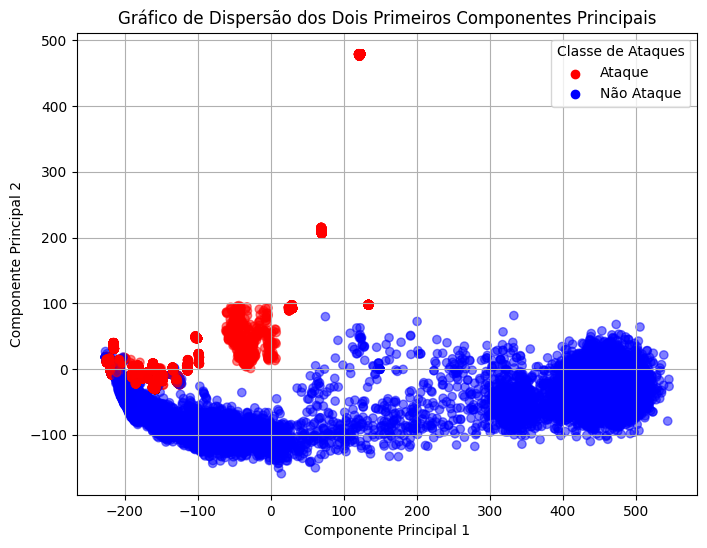

In [14]:
num_components = 2
X_pca_selected_2 = X2_pca[:, :num_components]

componente1_2 = X_pca_selected_2[:, 0]
componente2_2 = X_pca_selected_2[:, 1]

attack_classes = df['1024']

# Mapear os valores de ataque para cores específicas
colors = {-1: 'red', 1: 'blue'}
labels = {-1: 'Ataque', 1: 'Não Ataque'}

plt.figure(figsize=(8, 6))
plt.scatter(componente1_2, componente2_2, c=attack_classes.map(colors), alpha=0.5)
plt.title('Gráfico de Dispersão dos Dois Primeiros Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)

# Adicionar legenda manualmente
for attack_class, color in colors.items():
    plt.scatter([], [], c=color, label=labels[attack_class])
plt.legend(title='Classe de Ataques')

plt.show()

Claramente a normalização dos dados não alterou o resultado final. Há claramente uma área com muita sobreposição de ataques e não ataques.

### [Self Organizing Maps](https://medium.com/@abhinavr8/self-organizing-maps-ff5853a118d4)
Um Mapa Auto-Organizável (SOM) é um tipo de Rede Neural Artificial (RNA) que é treinada usando aprendizado não supervisionado para produzir uma representação discretizada de baixa dimensionalidade (tipicamente bidimensional) do espaço de entrada das amostras de treinamento, chamado de mapa, e é, portanto, um método para fazer redução de dimensionalidade.

O método compara os neurônios com todos os pontos do conjunto de dados, de forma que, a cada comparação, o neurônio mais próximo é considerado "vencedor", e todos os neurônios são reposicionados de forma a favorecer a relação do ponto comparado com o vencedor. 

Os neurônios não são independentes, por isso todos são reposicionados a cada passo do algoritmo. Isso acontece pois, durante o treinamento, os neurônios competem entre si para se tornarem os "vencedores" em relação aos padrões de entrada. Quando um neurônio é escolhido como o vencedor para um determinado padrão, ele não apenas ajusta seus próprios pesos, mas também influencia os neurônios vizinhos. 

(Explicação [aqui](https://www.youtube.com/watch?v=H9H6s-x-0YE&ab_channel=ThalesSehnK%C3%B6rting))

Vamos implementar usando a biblioteca [minisom](https://github.com/JustGlowing/minisom). É importante lembrar que esse método já divide nossos dados em classes separadas, independentemente das classificações de ataque. Após aplicá-lo, vamos comparar a saída do SOM com as saídas reais.

_Código não-paralelizado e funcional (pegando 5% das linhas para maior velocidade de processamento):_

In [11]:
def plot_soms(soms, params, training_data, target):
    num_soms = len(soms)
    n_rows = int(np.ceil(num_soms / 2))  # Adjust number of rows based on the number of SOMs
    fig, axs = plt.subplots(n_rows, 2, figsize=(15, 6 * n_rows))

    for i, (som, param) in enumerate(zip(soms, params)):
        row = i // 2
        col = i % 2
        ax = axs[row, col] if n_rows > 1 else axs[col]

        ax.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
        ax.set_title(f'Grid size: {param[0]}x{param[0]}; sigma: {param[1]}, learning rate: {param[2]}, iterations: {param[3]}')
        ax.grid()

        # Find winning neurons for each data point
        w_x, w_y = zip(*[som.winner(d) for d in training_data])
        w_x = np.array(w_x)
        w_y = np.array(w_y)

        # Define colors for different classes
        colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Add more colors as needed
        unique_classes = np.unique(target)
        for j, c in enumerate(unique_classes):
            idx_target = target == c
            ax.scatter(w_x[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) - .5) * 0.8,
                       w_y[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) - .5) * 0.8,
                       s=50, c=colors[j % len(colors)], label=f'Class {c}')  # Using modulo to cycle through colors

    plt.tight_layout()
    plt.show()


# Os parâmetros são: tamanho do lado do grid (sempre quadrado), sigma, taxa de aprendizado e iterações
def train_soms(training_df, training_data, params):
    trained_soms = []
    for size, sigma, learning_rate, iterations in params:
        som = MiniSom(size, size, training_df.shape[1], sigma=sigma, learning_rate=learning_rate)
        som.train(training_data, iterations)
        
        trained_soms.append(som)
        
    return trained_soms, params

Vamos analisar parâmetros diferentes com um grid 20x20 de neurônios (quando maior o grid, maior o custo computacional, mas teoricamente maior precisão)

In [12]:
# Preparando os dados para serem treinados
training_df = df.iloc[:, :-1]
training_df = training_df.sample(frac=0.05, random_state=42)
target = training_df[training_df.columns[-1]].values

# data normalization
training_data = (training_df - np.mean(training_df, axis=0)) / np.std(training_df, axis=0)
training_data = training_data.values  # Convert DataFrame to NumPy array

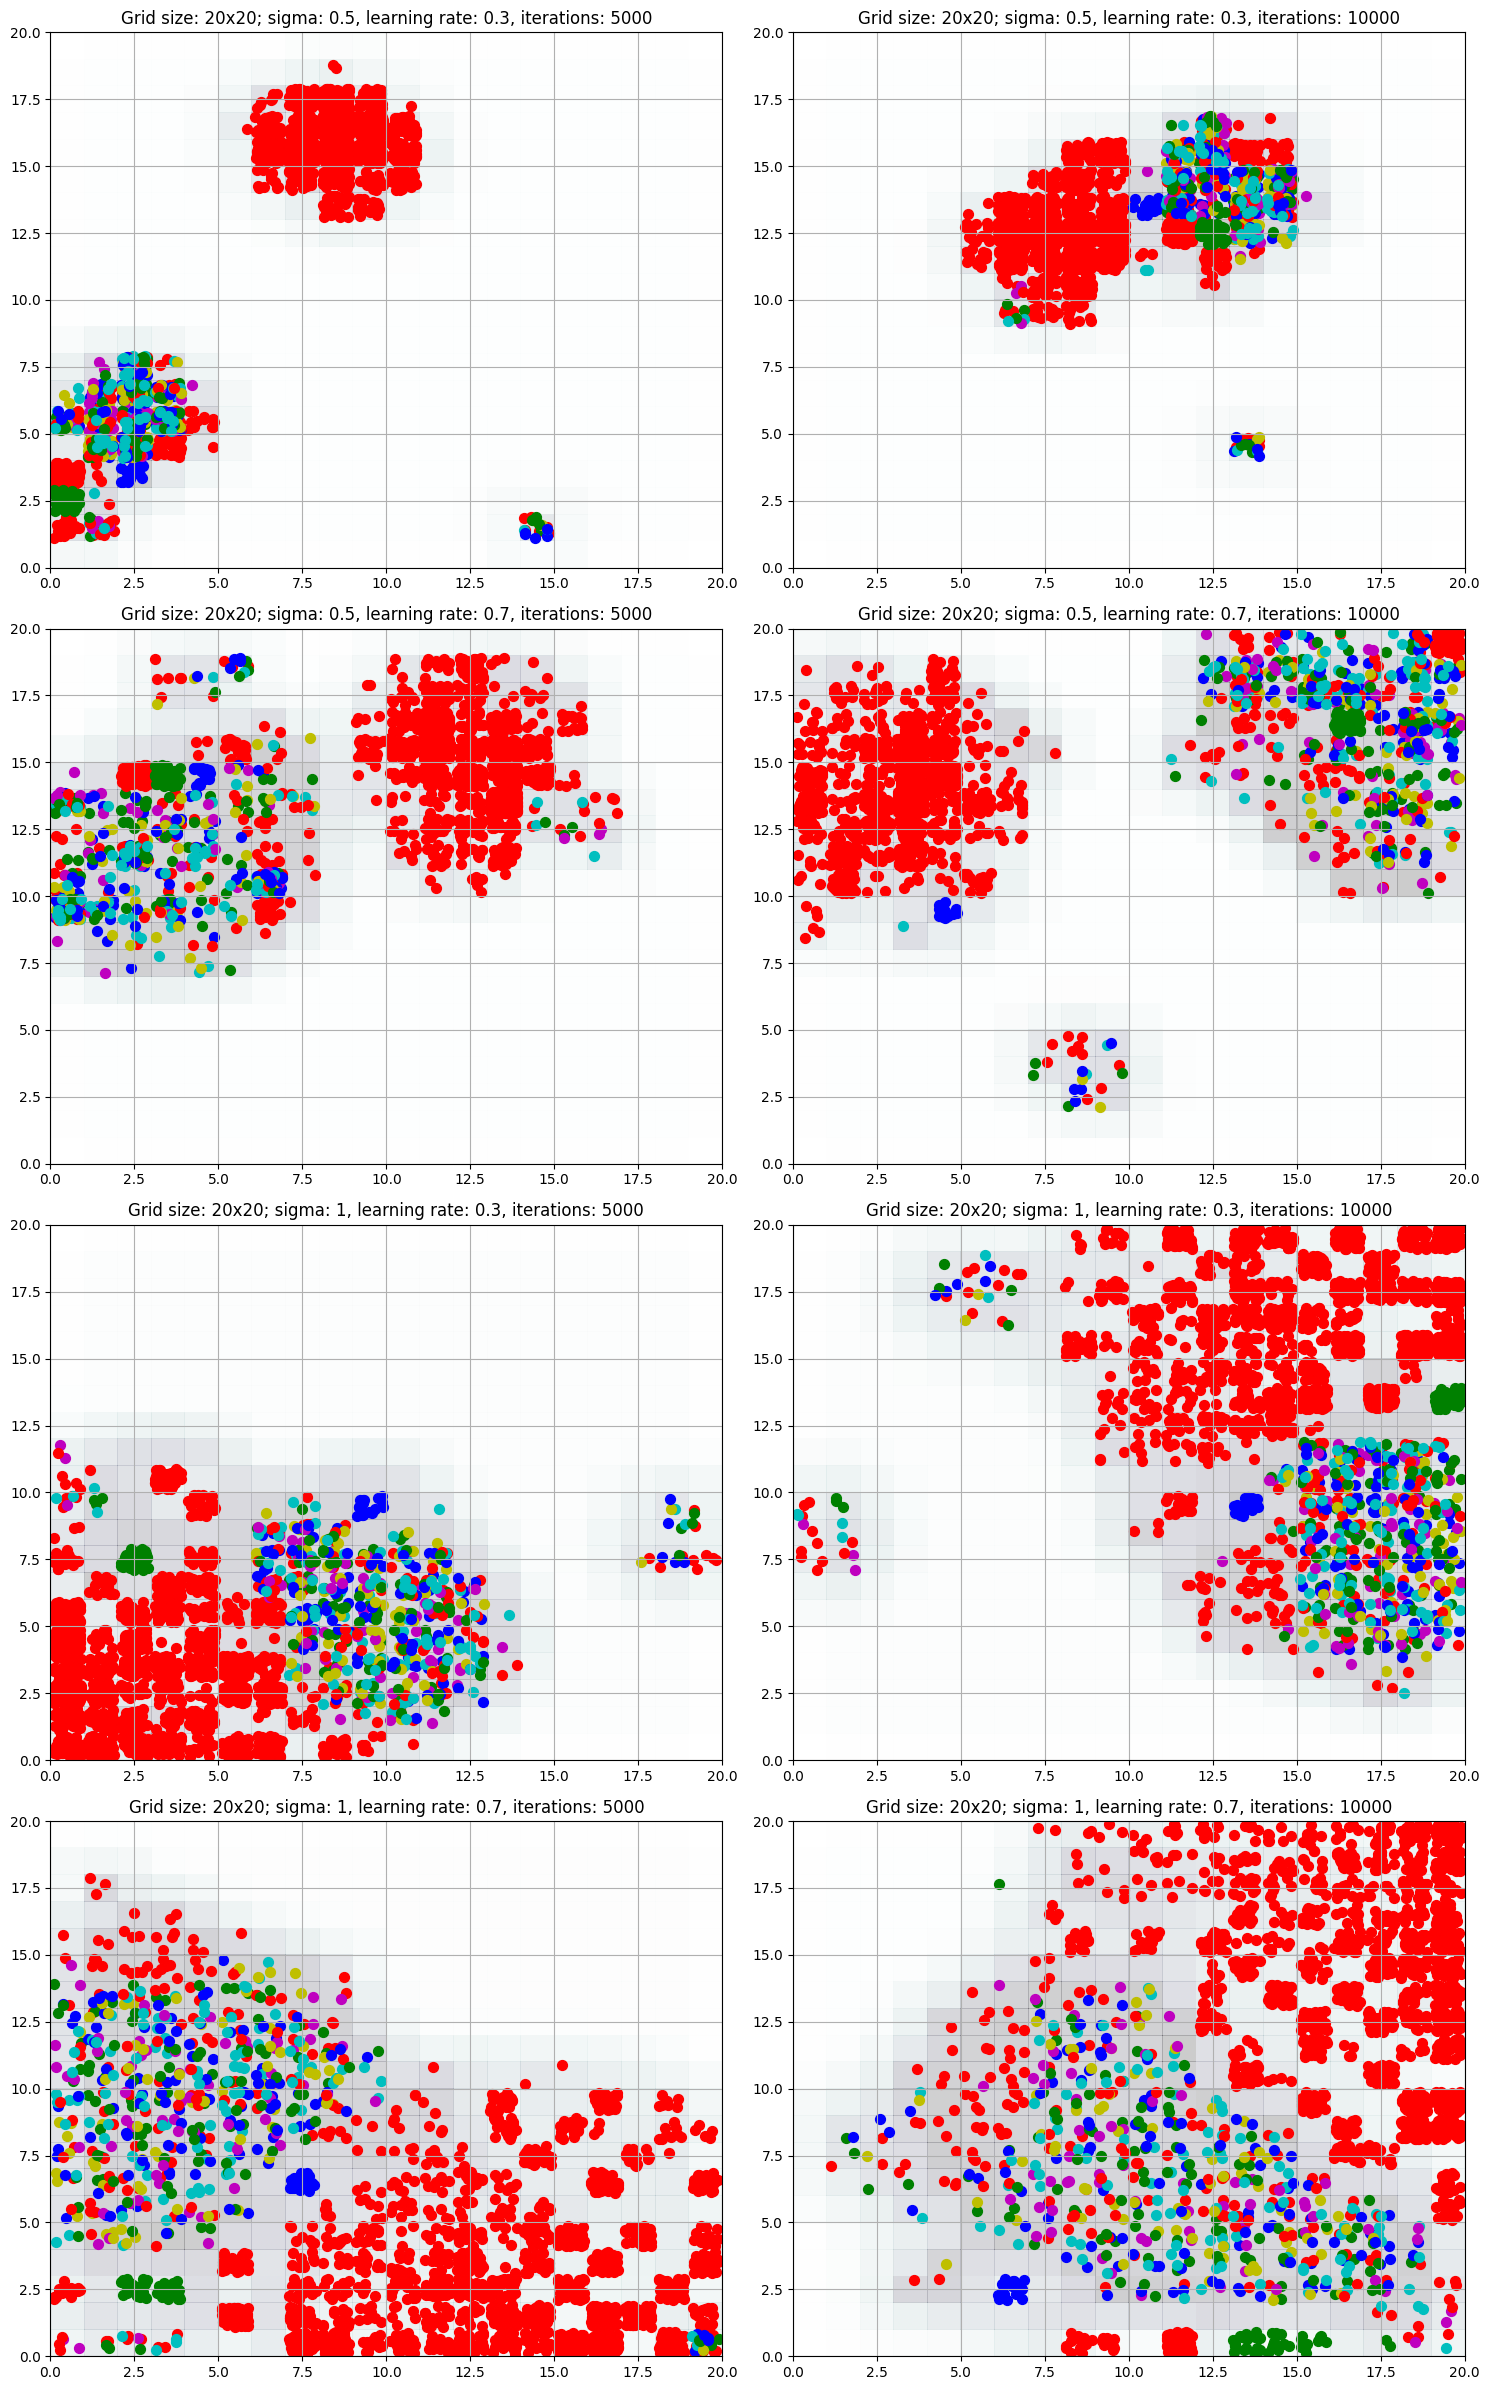

In [6]:
params1 = [
    (20, 0.5, 0.3, 5000),
    (20, 0.5, 0.3, 10000),
        
    (20, 0.5, 0.7, 5000),
    (20, 0.5, 0.7, 10000),
    
    (20, 1, 0.3, 5000),
    (20, 1, 0.3, 10000),

    (20, 1, 0.7, 5000),
    (20, 1, 0.7, 10000),
]

if not os.path.exists(f'trained_soms_params1.pkl'):
    trained_soms, params = train_soms(training_df, training_data, params1)
    with open('trained_soms_params1.pkl', 'wb') as f:
        pickle.dump(trained_soms, f)
        
with open('trained_soms_params1.pkl', 'rb') as f:
    trained_soms = pickle.load(f)
    plot_soms(trained_soms, params1, training_data, target)

## Modelo de Machine Learning
Para definir os modelos, segui o [guia do SciKit Learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).
Vamos primeiramente tratar os dados, separando as colunas da coluna-alvo, normalizando os dados e selecionando 30% deles como teste:

In [3]:
def analyse_ml_results(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(f'Verdadeiros Ataques: {cm[0][0]}, Falsos Não-Ataques: {cm[0][1]}')
    print(f'Falsos Ataques: {cm[1][0]}, Verdadeiros Não-Ataques: {cm[1][1]}')

    print(classification_report(y_test, y_pred))

X = df.iloc[:, :-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### Máquina de Vetores de Suporte
A primeira opção apontada pelo guia foi a [Máquina de Vetores de Suporte](https://pt.wikipedia.org/wiki/M%C3%A1quina_de_vetores_de_suporte), mais especificamente a função LinearSVC. É um algoritmo supervisionado que busca traçar uma reta no hiperplano para separá-lo em duas áreas, cada uma correspondendo a uma das duas classes possíveis.

Portanto, é um algoritmo que não funciona bem caso os dados não forem bem separáveis. Relembrando, nossos dados possuem sobreposição considerável após PCA em 2D, entretanto não sabemos como estão organizados utilizando todas as dimensões - a tentativa, então, ainda é válida.

In [7]:
linear_svc = LinearSVC(dual="auto", max_iter=100000)
linear_svc.fit(X_train, y_train)

# Vamos predizer o modelo para a classe de teste
y_pred = linear_svc.predict(X_test)

analyse_ml_results(y_test, y_pred)

Verdadeiros Ataques: 7265, Falsos Não-Ataques: 5
Falsos Ataques: 124, Verdadeiros Não-Ataques: 7111
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      7270
           1       1.00      0.98      0.99      7235

    accuracy                           0.99     14505
   macro avg       0.99      0.99      0.99     14505
weighted avg       0.99      0.99      0.99     14505



Por mais que nossa redução tenha nos dado um espaço bidimensional com sobreposição, é provável que tal coisa não aconteça quando usamos todas as dimensões, já que tivemos ótimos resultados.

### K-Nearest Neighbors
Vamos testar alguns valores de K, e plotar a média de [cross_val_scores](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) de cada um (baseado [nesse tutorial](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn)):

k = 1 value calculated
k = 2 value calculated
k = 3 value calculated
k = 4 value calculated
k = 5 value calculated
k = 6 value calculated
k = 7 value calculated
k = 8 value calculated
k = 9 value calculated


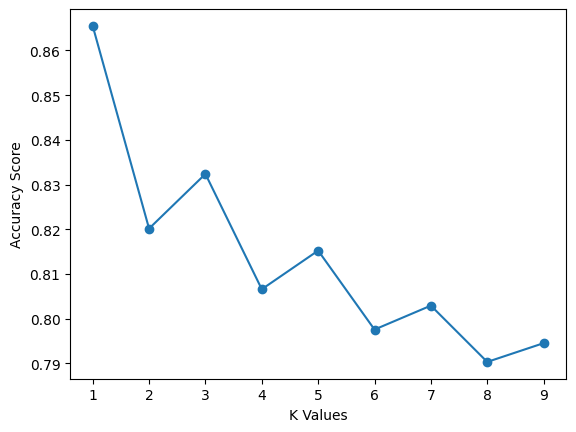

In [17]:
k_values = [i for i in range (1,10)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y)
    scores.append(np.mean(score))
    print(f'k = {k} value calculated')
    
plt.plot(k_values, scores, marker='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.show()

Como o melhor k foi de 1, com evidente decrescimento ao aumentarmos os k's, vamos verificar suas métricas:

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

analyse_ml_results(y_test, y_pred)

Verdadeiros Ataques: 7246, Falsos Não-Ataques: 24
Falsos Ataques: 2257, Verdadeiros Não-Ataques: 4978
              precision    recall  f1-score   support

          -1       0.76      1.00      0.86      7270
           1       1.00      0.69      0.81      7235

    accuracy                           0.84     14505
   macro avg       0.88      0.84      0.84     14505
weighted avg       0.88      0.84      0.84     14505



O número de não-ataques considerados como ataques foi bem mais alto do que o método anterior. 

### Árvores de Decisão
São estruturas que modelam decisões sobre os parâmetros dos nossos dados. Cada nó representa um teste, e cada galho que surge a partir dele é uma possível resposta a esse teste. Por exemplo, [uma árvore que modela a intenção de voto de estados Democratas ou Republicanos](https://www.youtube.com/watch?v=zs6yHVtxyv8&list=PLRZZr7RFUUmXfON6dvwtkaaqf9oV_C1LF&index=6) - um nó pode ser o nível de educação do estado, e, como é uma variável discreta, podemos discretizar para transformar as respostas em galhos (geralmente em quartis, no exemplo fazem uma binarização pela mediana).

Um problema comum desse modelo é o chamado Overfitting. Caso a árvore fique grande demais, ou considere muitos parâmetros ao mesmo tempo, ela pode se tornar enviesada por ser complexa demais, capturando ruído ou padrões irrelevantes nos dados.

#### [Random Forest](https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/)
É um método para classificação ou regressão que tenta impedir o Overfitting em Árvores de Decisão. Ele consiste em várias árvores de decisão pequenas e não-correlacionadas. A não-correlação de cada árvore é o que torna esse método mais performático do que uma árvore apenas, por exemplo, e o tamanho menor das árvores torna possível a obtenção grandes florestas com custo computacional razoavelmente baixo.

Para obtermos a aleatoriedade, podemos fazer dois métodos:
- Bootstrap Aggregating (Bagging): cada árvore é gerada em subconjuntos dos dados, selecionados via Bootstrap (dados podem estar presentes +1 vez na mesma árvore). O modelo apontado no output é escolhido por maioria simples;
- Boosting: cada árvore é treinada sequencialmente, e cada uma tenta corrigir os erros da anterior. Cada modelo recebe uma versão modificada do dataset, em que as instâncias mal-classificadas anteriormente ganham mais peso. A predição final é feita por voto com pesos.

Por padrão, a Random Forest do Sklearn usa Bagging.

In [18]:
rand_for = RandomForestClassifier().fit(X_train, y_train)
# Vamos predizer o modelo para a classe de teste
y_pred = rand_for.predict(X_test)

analyse_ml_results(y_test, y_pred)

Verdadeiros Ataques: 7258, Falsos Não-Ataques: 12
Falsos Ataques: 35, Verdadeiros Não-Ataques: 7200
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7270
           1       1.00      1.00      1.00      7235

    accuracy                           1.00     14505
   macro avg       1.00      1.00      1.00     14505
weighted avg       1.00      1.00      1.00     14505



#### Gradient Boosting
Usa o método de boosting descrito acima. Podemos aplicar com a implementação [Histogram-Based](https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/) do Sklearn.

>Instead of finding the split points on the sorted feature values, histogram-based algorithm buckets continuous feature values into discrete bins and uses these bins to construct feature histograms during training. Since the histogram-based algorithm is more efficient in both memory consumption and training speed, we will develop our work on its basis.

— LightGBM: A Highly Efficient Gradient Boosting Decision Tree, 2017. 

In [20]:
gradient_boost = HistGradientBoostingClassifier().fit(X_train, y_train)
# Vamos predizer o modelo para a classe de teste
y_pred = gradient_boost.predict(X_test)

analyse_ml_results(y_test, y_pred)

Verdadeiros Ataques: 7252, Falsos Não-Ataques: 18
Falsos Ataques: 34, Verdadeiros Não-Ataques: 7201
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7270
           1       1.00      1.00      1.00      7235

    accuracy                           1.00     14505
   macro avg       1.00      1.00      1.00     14505
weighted avg       1.00      1.00      1.00     14505



Nota-se que há diversos parâmetros para melhor controlar ambos os métodos de Árvore de Decisão acima, entretanto os resultados já estão muito bons em sua configuração default.

### Supervised Neural Network

In [5]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
analyse_ml_results(y_test, y_pred)

Verdadeiros Ataques: 7265, Falsos Não-Ataques: 5
Falsos Ataques: 177, Verdadeiros Não-Ataques: 7058
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      7270
           1       1.00      0.98      0.99      7235

    accuracy                           0.99     14505
   macro avg       0.99      0.99      0.99     14505
weighted avg       0.99      0.99      0.99     14505

